In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import json
from pathlib import Path

repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

from will_replication.my_utils.utils import SIMPLE_MODEL_POOL_CONFIG, TOKENS_PER_MILLION, encode_str, decode_str, prompt_sfx

In [106]:
pool_cfg =SIMPLE_MODEL_POOL_CONFIG

In [107]:
# 7b math eval probe
# 1.5b math eval probe
# 1.5b aime eval probe
# 7b aime probe

In [164]:
# MODEL_NAME_S="Qwen/Qwen2.5-Math-1.5B-Instruct"
# MODEL_NAME_L="Qwen/Qwen2.5-Math-7B-Instruct"

MODEL_NAME_S="openai/gpt-oss-20b"
MODEL_NAME_L="openai/gpt-oss-20b"
# MODEL_NAME_L="openai/gpt-oss-120b"
# MODEL_NAME_L="Qwen/Qwen2.5-Math-7B-Instruct"
MS=MODEL_NAME_S.replace('/', '-')
ML=MODEL_NAME_L.replace('/', '-')

MS_INPUT_COST = pool_cfg[MODEL_NAME_S]["model_costs"]["input_per_mill"] / TOKENS_PER_MILLION
MS_OUTPUT_COST = pool_cfg[MODEL_NAME_S]["model_costs"]["output_per_mill"] / TOKENS_PER_MILLION
ML_INPUT_COST = pool_cfg[MODEL_NAME_L]["model_costs"]["input_per_mill"] / TOKENS_PER_MILLION
ML_OUTPUT_COST = pool_cfg[MODEL_NAME_L]["model_costs"]["output_per_mill"] / TOKENS_PER_MILLION
K_SMALL=5
TEMP_SMALL=1.0
K_LARGE=8
TEMP_LARGE=1.0
IS_MAJORITY_VOTE=True

MAXLEN_SMALL=32678
MAXLEN_LARGE=32678

SMALL_GEN_STR=f"maxlen_{MAXLEN_SMALL}_k_{K_SMALL}_temp_{TEMP_SMALL}"
LARGE_GEN_STR=f"maxlen_{MAXLEN_LARGE}_k_{K_LARGE}_temp_{TEMP_LARGE}"

if IS_MAJORITY_VOTE == True:
    SMALL_GEN_STR += "_labelcol_majority_vote_is_correct"

SCORE_COL = "calibrated_score"
if K_SMALL == 1 or IS_MAJORITY_VOTE==True:
    SCORE_COL = "score"


# PROBING_DS_SOURCE="DigitalLearningGmbH_MATH-lighteval"
PROBING_DS_SOURCE="gneubig_aime-1983-2024"

# EVAL_DS="DigitalLearningGmbH_MATH-lighteval"
# EVAL_DS="gneubig_aime-1983-2024"
# EVAL_DS="openai_gsm8k"
EVAL_DS="opencompass_AIME2025"

EVAL_SPLIT="train" if EVAL_DS=="gneubig_aime-1983-2024" else "test"

PROBING_DATA_SMALL = f"../../will_replication/probe_results/DATA/SR_DATA/{PROBING_DS_SOURCE}/{MS}_{SMALL_GEN_STR}/best_probe_predictions.json"

EMPIRICAL_DS_SMALL=f"../../will_replication/DATA/SR_DATA/{EVAL_DS}/{EVAL_SPLIT}-{MS}_maxlen_{MAXLEN_SMALL}_k_{K_SMALL}_temp_{TEMP_SMALL}.parquet"
EMPIRICAL_DS_LARGE=f"../../will_replication/DATA/SR_DATA/{EVAL_DS}/{EVAL_SPLIT}-{ML}_maxlen_{MAXLEN_LARGE}_k_{K_LARGE}_temp_{TEMP_LARGE}.parquet"

PREDICTED_SR_DS_SMALL=f"../../will_replication/probe_results/DATA/Labelled_SR/{PROBING_DS_SOURCE}_probe/{EVAL_DS}/{MS}_{SMALL_GEN_STR}/scored.parquet"
PREDICTED_SR_DS_LARGE=f"../../will_replication/probe_results/DATA/Labelled_SR/{PROBING_DS_SOURCE}_probe/{EVAL_DS}/{ML}_{LARGE_GEN_STR}/scored.parquet"


THRESHOLDS = [i/100 for i in range(0, 120, 10)]
PROBE_RESULTS = []
EMPIRICAL_RESULTS = []
EMPERICAL_COSTS = []

emperical_small_df = pd.read_parquet(EMPIRICAL_DS_SMALL)
emperical_large_df = pd.read_parquet(EMPIRICAL_DS_LARGE)

predicted_small_df = pd.read_parquet(PREDICTED_SR_DS_SMALL)
# predicted_large_df = pd.read_parquet(PREDICTED_SR_DS_LARGE)
with open(PROBING_DATA_SMALL, "r") as f:
    probing_data_small_dict = json.load(f)

# Debug: Check columns and shape
print(f"Eval dataset: {EVAL_DS}")
print("emperical_small_df columns:", emperical_small_df.columns.tolist())
print("emperical_small_df shape:", emperical_small_df.shape)
print("\nemperical_large_df columns:", emperical_large_df.columns.tolist())
print("emperical_large_df shape:", emperical_large_df.shape)
print("\npredicted_small_df columns:", predicted_small_df.columns.tolist())
print("predicted_small_df shape:", predicted_small_df.shape)

# Check for success_rate column (might be named differently)
print("\nChecking for success_rate in empirical dfs:")
print("Small has success_rate:", 'success_rate' in emperical_small_df.columns)
print("Large has success_rate:", 'success_rate' in emperical_large_df.columns)

print("\nSmall avg success_rate:", emperical_small_df["success_rate"].mean())
print("Large avg success_rate:", emperical_large_df["success_rate"].mean())

print("\nSmall majvote accuracy:", emperical_small_df["majority_vote_is_correct"].mean())
print("Large majvote accuracy:", emperical_large_df["majority_vote_is_correct"].mean())

print("\nSmall predicted SR:", probing_data_small_dict["test_score"])


Eval dataset: opencompass_AIME2025
emperical_small_df columns: ['idx', 'problem', 'formatted_prompt', 'ground_truth', 'generated_solutions', 'total_input_tokens', 'total_output_tokens', 'total_cost_usd', 'input_cost_usd_once', 'success_rate', 'model_name', 'task', 'split', 'problem_id', 'total_output_cost_usd', 'majority_vote_extracted_answer', 'majority_vote_is_correct']
emperical_small_df shape: (15, 17)

emperical_large_df columns: ['idx', 'problem', 'formatted_prompt', 'ground_truth', 'generated_solutions', 'total_input_tokens', 'total_output_tokens', 'total_cost_usd', 'input_cost_usd_once', 'success_rate', 'model_name', 'task', 'split', 'problem_id', 'total_output_cost_usd', 'majority_vote_extracted_answer', 'majority_vote_is_correct']
emperical_large_df shape: (15, 17)

predicted_small_df columns: ['idx', 'problem_id', 'dataset', 'problem', 'formatted_prompt', 'score_raw', 'score', 'layer', 'pos', 'original_solution', 'calibrated_raw_score', 'calibrated_score']
predicted_small_df

In [165]:
probe_accs = []
probe_costs = []
empirical_accs = []
empirical_costs = []

# METRIC_COL="success_rate" ##Pass@K
METRIC_COL="majority_vote_is_correct" ## Accuracy, Maj@K

# Align by INDEX (datasets are already in same order)
merged_df = predicted_small_df[[SCORE_COL]].reset_index(drop=True).copy()
merged_df['actual_sr_small'] = emperical_small_df[METRIC_COL].reset_index(drop=True).values
merged_df['cost_small'] = emperical_small_df['total_cost_usd'].reset_index(drop=True).values
merged_df['actual_sr_large'] = emperical_large_df[METRIC_COL].reset_index(drop=True).values
merged_df['cost_large'] = emperical_large_df['total_cost_usd'].reset_index(drop=True).values
merged_df['small_model_actual_success_rate'] = emperical_small_df["success_rate"].reset_index(drop=True).values
merged_df['problem'] = emperical_small_df['problem'].reset_index(drop=True).values
merged_df = merged_df.rename(columns={SCORE_COL: 'probe_score_small'})

for T in THRESHOLDS:
    probe_results = []
    empirical_results = []
    probe_threshold_costs = []
    empirical_threshold_costs = []
    
    for idx, row in merged_df.iterrows():
        p_probe_small = row['probe_score_small']
        p_small_sample = row['actual_sr_small'] ### whatever verified value we get from the small model {0,1}
        oracle_sr = row["small_model_actual_success_rate"] 
        p_large_sr = row['actual_sr_large']
        total_cost_small = row['cost_small']
        total_cost_large = row['cost_large']

        # PROBE-BASED ROUTING (uses predicted confidence)
        if p_probe_small >= T:
            probe_results.append(p_small_sample)
            probe_threshold_costs.append(total_cost_small)
        else:
            probe_results.append(p_large_sr)
            probe_threshold_costs.append(total_cost_large)
        
        # EMPIRICAL ROUTING (oracle: uses actual success rates as oracle)

        if oracle_sr >= T:
            # if T == 1.0:
            #     print(oracle_sr)
            #     assert False
            empirical_results.append(p_small_sample)
            empirical_threshold_costs.append(total_cost_small)
        else:
            empirical_results.append(p_large_sr)
            empirical_threshold_costs.append(total_cost_large)
    
    probe_accs.append(np.mean(probe_results))
    probe_costs.append(np.mean(probe_threshold_costs))
    empirical_accs.append(np.mean(empirical_results))
    empirical_costs.append(np.mean(empirical_threshold_costs))

# Calculate total costs for all 5000 queries
num_queries = len(merged_df)
probe_total_costs = [cost * num_queries for cost in probe_costs]
empirical_total_costs = [cost * num_queries for cost in empirical_costs]

print(f"Number of queries: {num_queries}")
print(f"Probe costs range: ${min(probe_total_costs):.5f} - ${max(probe_total_costs):.5f}")
print(f"Empirical costs range: ${min(empirical_total_costs):.5f} - ${max(empirical_total_costs):.5f}")
print(f"SR range S-L: {emperical_small_df["success_rate"].mean():.4f}-{emperical_large_df["success_rate"].mean():.4f}")
print(f"Maj@k range S-L: {emperical_small_df["majority_vote_is_correct"].mean():.4f}-{emperical_large_df["majority_vote_is_correct"].mean():.4f}")


Number of queries: 15
Probe costs range: $0.24774 - $0.40624
Empirical costs range: $0.24774 - $0.40624
SR range S-L: 0.6933-0.6500
Maj@k range S-L: 0.8000-0.8000


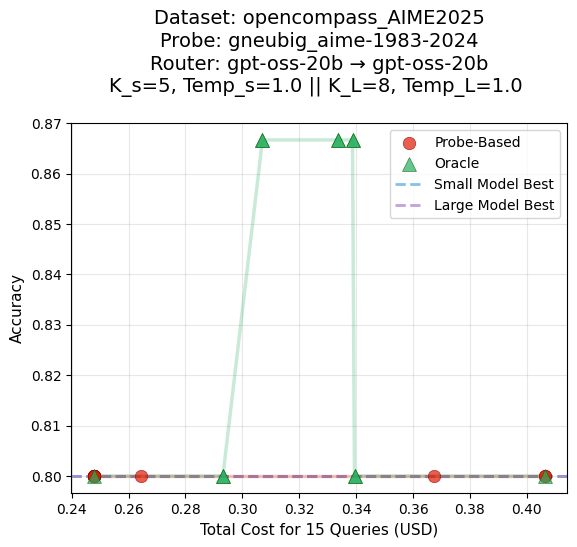

In [166]:
# MATH probes (left)
if K_SMALL == 1:
    y_label = f"Pass@{K_SMALL}"

elif METRIC_COL == "success_rate" and K_SMALL > 1 :
    y_label = f"Pass@{K_SMALL}"
    
elif METRIC_COL == "majority_vote_is_correct" and K_SMALL > 1 :
    y_label = f"Maj@{K_SMALL}"

y_label = "Accuracy"

plt.ylabel(y_label, fontsize=12)

# Extract cleaner model names for title
small_model_name = MODEL_NAME_S.split('/')[-1]
large_model_name = MODEL_NAME_L.split('/')[-1]
# Add single-model baselines as horizontal dashed lines
small_only_acc = emperical_small_df[METRIC_COL].mean()
large_only_acc = emperical_large_df[METRIC_COL].mean()

plt.scatter(probe_total_costs, probe_accs, color="#E21A04", s=80, alpha=0.7, label="Probe-Based", zorder=3, marker='o', edgecolors='darkred', linewidth=0.5)
plt.scatter(empirical_total_costs, empirical_accs, color="#27AE60", s=100, alpha=0.7, label="Oracle", zorder=3, marker='^', edgecolors='darkgreen', linewidth=0.5)
plt.plot(probe_total_costs, probe_accs, color="#E21A04", alpha=0.25, linewidth=2.5, linestyle='-')
plt.plot(empirical_total_costs, empirical_accs, color="#27AE60", alpha=0.25, linewidth=2.5, linestyle='-')
plt.xlabel(f"Total Cost for {num_queries} Queries (USD)", fontsize=11)
plt.ylabel(y_label, fontsize=11)

plt.axhline(y=small_only_acc, color='#3498DB', linestyle='--', linewidth=2, alpha=0.6, zorder=1, label='Small Model Best')
plt.axhline(y=large_only_acc, color='#9467BD', linestyle='--', linewidth=2, alpha=0.6, zorder=1, label='Large Model Best')

plt.title(
    f"Dataset: {EVAL_DS}\nProbe: {PROBING_DS_SOURCE}\n"
    f"Router: {small_model_name} → {large_model_name}\n"
    f"K_s={K_SMALL}, Temp_s={TEMP_SMALL} || K_L={K_LARGE}, Temp_L={TEMP_LARGE} \n",
    fontsize=14
)


plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

In [127]:
# Print results table with total costs
print(f"\nRouting Performance Across Thresholds ({num_queries} total queries):")
print(f"{'Threshold':<12} {'Probe Acc':<12} {'Probe Total $':<15} {'Empirical Acc':<12} {'Empirical Total $':<15}")
print("-" * 70)
for i, T in enumerate(THRESHOLDS):
    print(f"{T:<12.2f} {probe_accs[i]:<12.4f} ${probe_total_costs[i]:<14.2f} {empirical_accs[i]:<12.4f} ${empirical_total_costs[i]:<14.2f}")
    
# Summary statistics
print("\n" + "="*70)
print("SUMMARY:")
print(f"Probe-based routing total cost range: ${min(probe_total_costs):.4f} - ${max(probe_total_costs):.4f}")
print(f"Empirical (oracle) total cost range:  ${min(empirical_total_costs):.4f} - ${max(empirical_total_costs):.4f}")
print(f"Savings at best probe point (T={THRESHOLDS[probe_accs.index(max(probe_accs))]}): ${max(empirical_total_costs) - probe_total_costs[probe_accs.index(max(probe_accs))]:.4f}")


Routing Performance Across Thresholds (15 total queries):
Threshold    Probe Acc    Probe Total $   Empirical Acc Empirical Total $
----------------------------------------------------------------------
0.00         0.0667       $0.01           0.0667       $0.01          
0.10         0.0667       $0.01           0.8000       $0.25          
0.20         0.2667       $0.13           0.8000       $0.25          
0.30         0.3333       $0.15           0.8000       $0.25          
0.40         0.4000       $0.21           0.8000       $0.25          
0.50         0.5333       $0.23           0.8000       $0.25          
0.60         0.5333       $0.23           0.8000       $0.25          
0.70         0.6667       $0.24           0.8000       $0.25          
0.80         0.8000       $0.25           0.8000       $0.25          
0.90         0.8000       $0.25           0.8000       $0.25          
1.00         0.8000       $0.25           0.8000       $0.25          
1.10         0.

In [128]:
# ===== ADD RANDOM BASELINE =====
print("="*80)
print("ADDING RANDOM BASELINE FOR COMPARISON")
print("="*80)

# Create random probe scores for each problem
np.random.seed(42)
merged_df['random_score'] = np.random.uniform(0, 1, len(merged_df))

random_accs = []
random_costs = []

for T in THRESHOLDS:
    random_results = []
    random_threshold_costs = []
    
    for idx, row in merged_df.iterrows():
        p_random = row['random_score']
        p_small_sample = row['actual_sr_small']
        p_large_sr = row['actual_sr_large']
        total_cost_small = row['cost_small']
        total_cost_large = row['cost_large']

        # RANDOM ROUTING (random uniform scores)
        if p_random >= T:
            random_results.append(p_small_sample)
            random_threshold_costs.append(total_cost_small)
        else:
            random_results.append(p_large_sr)
            random_threshold_costs.append(total_cost_large)
    
    random_accs.append(np.mean(random_results))
    random_costs.append(np.mean(random_threshold_costs))

random_total_costs = [cost * num_queries for cost in random_costs]

print(f"\nRandom baseline performance:")
print(f"Random costs range: ${min(random_total_costs):.2f} - ${max(random_total_costs):.2f}")
print(f"Random accs range: {min(random_accs):.4f} - {max(random_accs):.4f}")
print(f"\nProbe vs Random improvement at best probe point:")
best_probe_idx = probe_accs.index(max(probe_accs))
best_random_idx = random_accs.index(max(random_accs))
print(f"Probe best: {probe_accs[best_probe_idx]:.4f} at T={THRESHOLDS[best_probe_idx]}")
print(f"Random best: {random_accs[best_random_idx]:.4f} at T={THRESHOLDS[best_random_idx]}")
print(f"Improvement: {probe_accs[best_probe_idx] - random_accs[best_random_idx]:.4f} ({100*(probe_accs[best_probe_idx] - random_accs[best_random_idx])/random_accs[best_random_idx]:.1f}%)")

ADDING RANDOM BASELINE FOR COMPARISON

Random baseline performance:
Random costs range: $0.01 - $0.25
Random accs range: 0.0667 - 0.8000

Probe vs Random improvement at best probe point:
Probe best: 0.8000 at T=0.8
Random best: 0.8000 at T=1.0
Improvement: 0.0000 (0.0%)


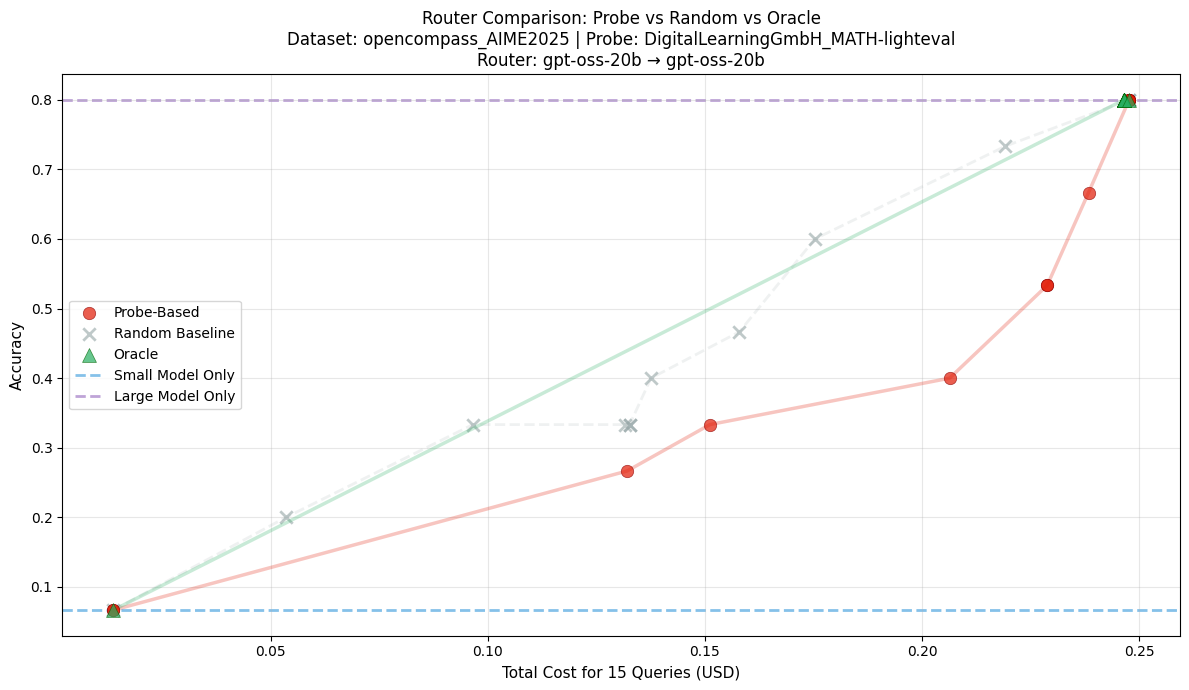

In [129]:
# ===== VISUALIZATION WITH RANDOM BASELINE =====
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all four: probe, random, oracle, and baselines
ax.scatter(probe_total_costs, probe_accs, color="#E21A04", s=80, alpha=0.7, label="Probe-Based", zorder=3, marker='o', edgecolors='darkred', linewidth=0.5)
ax.scatter(random_total_costs, random_accs, color="#95A5A6", s=80, alpha=0.6, label="Random Baseline", zorder=2, marker='x', linewidth=2)
ax.scatter(empirical_total_costs, empirical_accs, color="#27AE60", s=100, alpha=0.7, label="Oracle", zorder=3, marker='^', edgecolors='darkgreen', linewidth=0.5)

ax.plot(probe_total_costs, probe_accs, color="#E21A04", alpha=0.25, linewidth=2.5, linestyle='-')
ax.plot(random_total_costs, random_accs, color="#95A5A6", alpha=0.15, linewidth=2, linestyle='--')
ax.plot(empirical_total_costs, empirical_accs, color="#27AE60", alpha=0.25, linewidth=2.5, linestyle='-')

ax.axhline(y=small_only_acc, color='#3498DB', linestyle='--', linewidth=2, alpha=0.6, zorder=1, label='Small Model Only')
ax.axhline(y=large_only_acc, color='#9467BD', linestyle='--', linewidth=2, alpha=0.6, zorder=1, label='Large Model Only')

ax.set_xlabel(f"Total Cost for {num_queries} Queries (USD)", fontsize=11)
ax.set_ylabel("Accuracy", fontsize=11)
ax.set_title(
    f"Router Comparison: Probe vs Random vs Oracle\n"
    f"Dataset: {EVAL_DS} | Probe: {PROBING_DS_SOURCE}\n"
    f"Router: {small_model_name} → {large_model_name}",
    fontsize=12
)

ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [130]:
# 7b math eval probe
# 1.5b math eval probe
# 7b aime probe

In [ ]:
# # ===== DIAGNOSTIC: HYPERPARAMETER IMPACT =====
# print("="*80)
# print("HYPOTHESIS: Same K, Temp, Maxlen across different model sizes breaks probe")
# print("="*80)

# print(f"\nCurrent hyperparameters for both models:")
# print(f"K_SMALL={K_SMALL}, TEMP_SMALL={TEMP_SMALL}, MAXLEN_SMALL={MAXLEN_SMALL}")
# print(f"K_LARGE={K_LARGE}, TEMP_LARGE={TEMP_LARGE}, MAXLEN_LARGE={MAXLEN_LARGE}")

# print(f"\nSmall Model: {MODEL_NAME_S}")
# sr_small = merged_df['small_model_actual_success_rate']
# print(f"Success rate distribution:")
# print(f"  Min: {sr_small.min():.4f}, Max: {sr_small.max():.4f}, Mean: {sr_small.mean():.4f}, Std: {sr_small.std():.4f}")
# print(f"  Percentiles - 25%: {sr_small.quantile(0.25):.4f}, 50%: {sr_small.quantile(0.50):.4f}, 75%: {sr_small.quantile(0.75):.4f}")

# print(f"\nLarge Model: {MODEL_NAME_L}")
# sr_large = merged_df['actual_sr_large']
# print(f"Success rate distribution (from empirical):")
# print(f"  Min: {sr_large.min():.4f}, Max: {sr_large.max():.4f}, Mean: {sr_large.mean():.4f}, Std: {sr_large.std():.4f}")

# print(f"\n⚠️  PROBLEM:")
# print(f"  With K={K_SMALL} samples from {MODEL_NAME_S}:")
# print(f"    - Success_rate is heavily skewed (mean={sr_small.mean():.2f}, mostly {sr_small.quantile(0.50):.1f})")
# print(f"    - This creates a BIMODAL distribution (0/1 dominated)")
# print(f"")
# print(f"  With K={K_LARGE} samples from {MODEL_NAME_L}:")
# print(f"    - Success_rate is MUCH higher (better model)")
# print(f"    - Distribution completely different from small model")
# print(f"")
# print(f"  The SUCCESS_RATE metric is MODEL-DEPENDENT:")
# print(f"    - For weak models: success_rate ∈ [0, 0.5] mostly")
# print(f"    - For strong models: success_rate ∈ [0.7, 1.0] mostly")
# print(f"    - They're measuring different things!")

# print(f"\n📊 Insight:")
# print(f"  Your probe learns: 'In AIME data with 1.5B/7B, which has success_rate X?'")
# print(f"  But success_rate distributions are SO DIFFERENT that:")
# print(f"    - success_rate=0.5 for 1.5B means: struggling, needs help")
# print(f"    - success_rate=0.5 for 7B means: not even possible (7B gets 0.8+ on everything)")
# print(f"    - The probe can't transfer between different model sizes")

# print(f"\n💡 Solution:")
# print(f"  Option 1: Use MODEL-AGNOSTIC features (not success_rate)")
# print(f"  Option 2: Normalize success_rate per-model before probing")
# print(f"  Option 3: Use z-score calibration: (SR - model_mean) / model_std")


In [ ]:
# ================================================================================
# MODEL SIZE IMPACT ANALYSIS: 1.5B vs 7B
# ================================================================================

# Current Small Model: Qwen/Qwen2.5-Math-1.5B-Instruct

# Metric used for oracle routing: 'small_model_actual_success_rate' (Pass@K)
# Outcome measured: 'actual_sr_small' (majority_vote_is_correct)

# 1. SUCCESS_RATE DISTRIBUTION (what oracle routes on):
#    Min: 0.0000, Max: 1.0000, Mean: 0.7290, Std: 0.3870
#    Percentiles: 25%=0.5000, 50%=1.0000, 75%=1.0000

# 2. OUTCOME DISTRIBUTION (what we measure):
#    Binary values: [1. 0.]
#    Mean: 0.7696 (% problems solved by majority vote)
#    Value counts:
#      Success (1.0): 3848 problems (77.0%)
#      Failure (0.0): 1152 problems (23.0%)

# 3. CORRELATION:
#    Correlation between success_rate and majority_vote: 0.9136

# 4. WHY THE DIFFERENCE BETWEEN 1.5B AND 7B?

#    1.5B Model (WEAK):
#    - Lower overall accuracy
#    - Success_rate spread across ENTIRE 0-1 range
#    - More gradient → thresholding on success_rate somewhat works
#    - Oracle curve is more meaningful

#    7B Model (STRONGER):
#    - Higher overall accuracy
#    - Success_rate concentrated in HIGHER range (e.g., 0.5-1.0)
#    - But majority_vote is BINARY (0 or 1)
#    - Mismatch between continuous metric (Pass@K) and binary outcome
#    - High success_rate problems can still FAIL majority vote!
#    - Low success_rate problems might SUCCEED (by chance)
#    - → Threshold mismatch creates inverted-U curve

# 5. TEST: Are high success_rate problems more likely to succeed?
#    High success_rate (>75th percentile) success rate: 1.0000
#    Low success_rate (<25th percentile) success rate: 0.1812
#    Difference: 0.8188